In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from multi_group_dorm_simulation import MultiGroupDormSimulation
from load_params import load_params

In [2]:
def init_multi_group_sim(total_groups, 
                         total_population, 
                         total_contacts, 
                         within_group_contact_fraction,
                         use_adaptive_protocol=False,
                         max_time_to_big_test=None):
   
    if use_adaptive_protocol:
        quarantine_test_fraction=1.0
    else:
        quarantine_test_fraction = 2/7
    
    
    return MultiGroupDormSimulation(
        num_dorms = total_groups,
        dorm_population = total_population,
        non_dorm_population = 0,
        intra_dorm_contacts = total_contacts * within_group_contact_fraction,
        inter_dorm_contacts = total_contacts * (1 - within_group_contact_fraction),
        intra_non_dorm_contacts = 0,
        inter_non_dorm_contacts = 0,
        dorm_test_rate = 2/7,
        non_dorm_test_rate = 0,
        quarantine_delay=max_time_to_big_test,
        quarantine_contacts_multiplier=1,
        quarantine_test_fraction = quarantine_test_fraction,
        safe_days_until_unquarantine=0,
        dorm_outside_infection_p=None,
        initial_dorm_prevalence=0.1,
        base_config='../src/simulations_v2/params/baseline_testing/steady_state/nominal/ug_dorm.yaml')

In [27]:
def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()


def run_sims(within_group_contact_frac, 
               use_adaptive_protocol,
               max_time_to_big_test,
               procnum, return_dict, ntrajectories):
    
    cum_lockdown_status = []
    cum_infections = []
    for trajectory_num in range(ntrajectories):
        sim = init_multi_group_sim(100, 10000, 10, within_group_contact_frac, use_adaptive_protocol,
                                  max_time_to_big_test)
        sim.configure_lockdown(post_lockdown_interaction_matrix=sim.interaction_matrix * 0.1,
                          new_case_sims_list=[True] * len(sim.sims),
                          new_cases_threshold=100,
                          new_cases_time_window=14)
        quarantine_dorm_counts, lockdown_statuses, sim_df = sim.run_new_trajectory(12*7)
        cum_lockdown_status.append(lockdown_statuses[-1])
        cum_infections.append(get_cum_infections(sim_df))
        
    return_dict[procnum] = {'avg_infections': np.mean(cum_infections), 
                            'avg_infections_std': np.std(cum_infections),
                            'prob_lockdown': np.mean(cum_lockdown_status),
                            'prob_lockdown_std': np.std(cum_lockdown_status)}

In [ ]:
import multiprocessing, time, itertools

manager = multiprocessing.Manager()
return_dict = manager.dict()

within_group_contact_fracs = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
#within_group_contact_fracs = [0.5,0.9]
jobs = []

ntrajectories = 100

start = time.time()
idx = 0
idx_mapping = {}
mapping_to_idx = {}
for within_group_frac, big_test_time, use_adaptive_protocol in itertools.product(
                                                within_group_contact_fracs, 
                                                [1],#[1,2,3],
                                                [True, False]):
    if not use_adaptive_protocol and big_test_time > 1:
        continue
    p = multiprocessing.Process(target=run_sims, 
                                args=(within_group_frac, use_adaptive_protocol, big_test_time,
                                      idx,return_dict, ntrajectories))
    idx_mapping[idx] = (within_group_frac, big_test_time, use_adaptive_protocol)
    mapping_to_idx[(within_group_frac, big_test_time, use_adaptive_protocol)] = idx
    jobs.append(p)
    p.start()
    idx += 1
    
for proc in jobs:
        proc.join()
end = time.time()
print("elapsed time: {:.2f} seconds".format(end-start))

In [7]:
print("elapsed time: {:.2f} seconds".format(end-start))

elapsed time: 12540.05 seconds


In [42]:
def get_shutdown_prob(protocol, within_group_frac):
    idx = mapping_to_idx[(within_group_frac, protocol[0], protocol[1])]
    print(return_dict[idx])
    return return_dict[idx]['prob_lockdown']
def get_average_infections(protocol, within_group_frac):
    idx = mapping_to_idx[(within_group_frac, protocol[0], protocol[1])]
    return return_dict[idx]['avg_infections']

In [12]:
mapping_to_idx.keys()

dict_keys([(0.5, 1, True), (0.5, 1, False), (0.5, 2, True), (0.5, 3, True), (0.55, 1, True), (0.55, 1, False), (0.55, 2, True), (0.55, 3, True), (0.6, 1, True), (0.6, 1, False), (0.6, 2, True), (0.6, 3, True), (0.65, 1, True), (0.65, 1, False), (0.65, 2, True), (0.65, 3, True), (0.7, 1, True), (0.7, 1, False), (0.7, 2, True), (0.7, 3, True), (0.75, 1, True), (0.75, 1, False), (0.75, 2, True), (0.75, 3, True), (0.8, 1, True), (0.8, 1, False), (0.8, 2, True), (0.8, 3, True), (0.85, 1, True), (0.85, 1, False), (0.85, 2, True), (0.85, 3, True), (0.9, 1, True), (0.9, 1, False), (0.9, 2, True), (0.9, 3, True)])

In [31]:
return_dict[1]

{'avg_infections': 36.7,
 'avg_infections_std': 24.714570601165622,
 'prob_lockdown': 0.0,
 'prob_lockdown_std': 0.0}

In [43]:
adaptive_protocols = [(1, True),  (1, False)]

adaptive_protocol_shutdown_probs = {k:[] for k in adaptive_protocols}
adaptive_protocol_average_infections = {k:[] for k in adaptive_protocols}

for within_group_frac in within_group_contact_fracs:
    for protocol in adaptive_protocols:
        adaptive_protocol_shutdown_probs[protocol].append(get_shutdown_prob(protocol, within_group_frac))
        adaptive_protocol_average_infections[protocol].append(get_average_infections(protocol, within_group_frac))
    

{'avg_infections': 28.7, 'avg_infections_std': 20.923909768492123, 'prob_lockdown': 0.0, 'prob_lockdown_std': 0.0}
{'avg_infections': 36.7, 'avg_infections_std': 24.714570601165622, 'prob_lockdown': 0.0, 'prob_lockdown_std': 0.0}
{'avg_infections': 27.6, 'avg_infections_std': 12.191800523302534, 'prob_lockdown': 0.0, 'prob_lockdown_std': 0.0}
{'avg_infections': 1049.7, 'avg_infections_std': 2983.6121748645546, 'prob_lockdown': 0.1, 'prob_lockdown_std': 0.30000000000000004}
{'avg_infections': 26.4, 'avg_infections_std': 11.646458689232535, 'prob_lockdown': 0.0, 'prob_lockdown_std': 0.0}
{'avg_infections': 1034.3, 'avg_infections_std': 2988.6342717033813, 'prob_lockdown': 0.1, 'prob_lockdown_std': 0.30000000000000004}
{'avg_infections': 26.6, 'avg_infections_std': 12.760877712759415, 'prob_lockdown': 0.0, 'prob_lockdown_std': 0.0}
{'avg_infections': 22.6, 'avg_infections_std': 12.642784503423286, 'prob_lockdown': 0.0, 'prob_lockdown_std': 0.0}
{'avg_infections': 29.8, 'avg_infections_std

Text(0,0.5,'Average Infections')

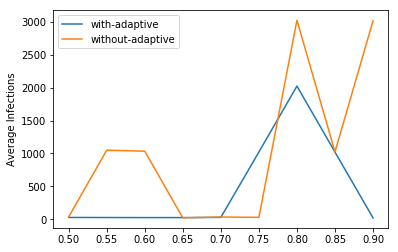

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(within_group_contact_fracs, adaptive_protocol_average_infections[(1,True)], label='with-adaptive')
plt.plot(within_group_contact_fracs, adaptive_protocol_average_infections[(1,False)], label='without-adaptive')
plt.legend(loc='best')
plt.ylabel("Average Infections")

Text(0,0.5,'Shutdown Probability')

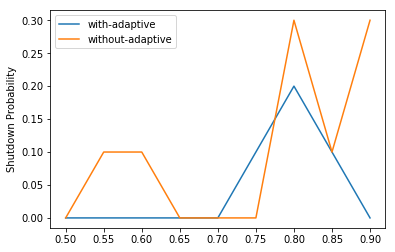

In [40]:
plt.plot(within_group_contact_fracs, adaptive_protocol_shutdown_probs[(1,True)], label='with-adaptive')
plt.plot(within_group_contact_fracs, adaptive_protocol_shutdown_probs[(1,False)], label='without-adaptive')
plt.legend(loc='best')
plt.ylabel("Shutdown Probability")

# scrap code below

In [5]:
sim = init_multi_group_sim(100,10000,10,0.5,True,4)

In [6]:
sim.configure_lockdown(post_lockdown_interaction_matrix=sim.interaction_matrix * 0.1,
                      new_case_sims_list=[True] * len(sim.sims),
                      new_cases_threshold=100,
                      new_cases_time_window=14)

In [7]:
quarantine_dorm_counts, lockdown_statuses, sim_df = sim.run_new_trajectory(12*7)

just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: {79}
just ran step() with these quarantines: {17}
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantines: set()
just ran step() with these quarantin

In [8]:
sim_df

,S,QS,QI,R,E_0,E_1,E_2,E_3,E_4,E_5,...,SyID_severe_17,SyID_severe_18,SyID_severe_19,cumulative_mild,cumulative_severe,cumulative_outside_infections,severity_0,severity_1,severity_2,severity_3
0,10000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9994,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9993,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9993,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9992,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,9989,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,9988,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,9987,13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9987,13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9985,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
lockdown_statuses

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [5]:
sim.interaction_matrix * 0.1

array([[0.5       , 0.00505051, 0.00505051, ..., 0.00505051, 0.00505051,
        0.        ],
       [0.00505051, 0.5       , 0.00505051, ..., 0.00505051, 0.00505051,
        0.        ],
       [0.00505051, 0.00505051, 0.5       , ..., 0.00505051, 0.00505051,
        0.        ],
       ...,
       [0.00505051, 0.00505051, 0.00505051, ..., 0.5       , 0.00505051,
        0.        ],
       [0.00505051, 0.00505051, 0.00505051, ..., 0.00505051, 0.5       ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])